<a href="https://colab.research.google.com/github/danielmlow/tutorials/blob/main/speech/audio_embeddings_cka_cca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Extract audio deep learning embeddings and explore similarites using CKA and CCA
# Author: Gasser Elbanna (EPFL, MIT)
License: Apache 2.0

In this tutorial, we will extract speech representations from two different self-supervised models (Hybrid BYOL-S and Wav2Vec 2.0) and explore their similarities using CKA and CCA. 

*   The code for extracting Hybrid BYOL-S is adapted from: https://github.com/GasserElbanna/serab-byols
*   The code for extracting Wav2Vec 2.0 is adapted from: https://colab.research.google.com/drive/17Hu1pxqhfMisjkSgmM2CnZxfqDyn2hSY?usp=sharing
*   The code for computing similarity (CKA and CCA) is adapted from: https://colab.research.google.com/github/google-research/google-research/blob/master/representation_similarity/Demo.ipynb





### Note: make sure to restart runtime after running the cell below to import the package.

In [1]:
!git clone https://github.com/GasserElbanna/serab-byols.git
!python3 -m pip install -e ./serab-byols
!pip install -q tqdm==4.60.0
!pip install -q speechbrain
!pip install -q transformers

Cloning into 'serab-byols'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 250 (delta 10), reused 16 (delta 6), pack-reused 228
Receiving objects: 100% (250/250), 112.55 MiB | 19.13 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Checking out files: 100% (35/35), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/serab-byols
  Running setup.py develop for serab-byols
     |████████████████████████████████| 75 kB 3.6 MB/s 
     |████████████████████████████████| 498 kB 26.5 MB/s 
     |████████████████████████████████| 163 kB 43.8 MB/s 
     |████████████████████████████████| 1.3 MB 41.4 MB/s 
     |████████████████████████████████| 109 kB 57.6 MB/s 
     |████████████████████████████████| 500 kB 58.1 MB/s 
     |████████████████████████████████| 5.3 MB 26.0 MB/s 
     |███████████████████████████████

In [ ]:
# need to exist for serab_byols to import
import os
os.kill(os.getpid(), 9)
# then you can run following cell without reinstalling packages

In [1]:
# Import needed packages
import torch
import torchaudio
import librosa
import serab_byols
import numpy as np
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
from speechbrain.lobes.models.huggingface_wav2vec import HuggingFaceWav2Vec2

### We will use a speech emotion recognition dataset (EmoDB) as an example for speech utterances.

In [6]:
# Download EmoDB dataset (speech emotion recognition dataset comprises 535 recording spoken in german by 10 actors with 7 emotions)

# Read the audio paths for the dataset
wav_files = glob('/content/wav/*.wav')
if wav_files == 0:
  !wget -q http://emodb.bilderbar.info/download/download.zip
  !unzip -q download.zip

In [8]:
# Read the audio paths for the dataset
wav_files = glob('/content/wav/*.wav')
print(f'Number of audio samples: {len(wav_files)}')

Number of audio samples: 535


In [9]:
# Play an audio example
import IPython
IPython.display.Audio(wav_files[0])

In [10]:
def plot_spectrogram(mel_spec, title=None, ylabel="Freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10,5))
    axs.set_title(title or "Log Mel Spectrogram", fontsize=20)
    axs.set_ylabel(ylabel, fontsize=20)
    axs.set_xlabel("Frame", fontsize=20)
    im = axs.imshow(mel_spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

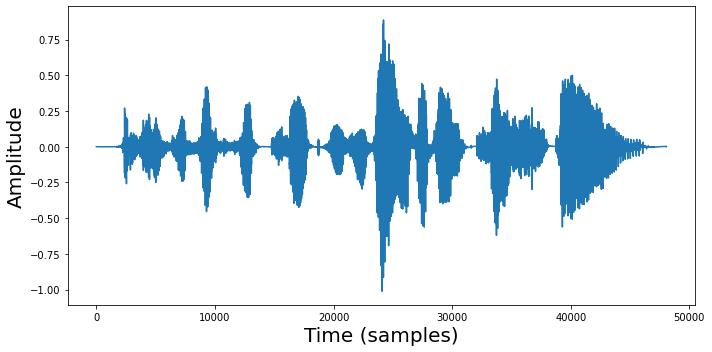

In [11]:
# Plot the waveform of the played example
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
y, sr = librosa.load(wav_files[0])
ax.plot(y)
ax.set_xlabel('Time (samples)', fontsize=20)
ax.set_ylabel('Amplitude', fontsize=20)
plt.tight_layout()

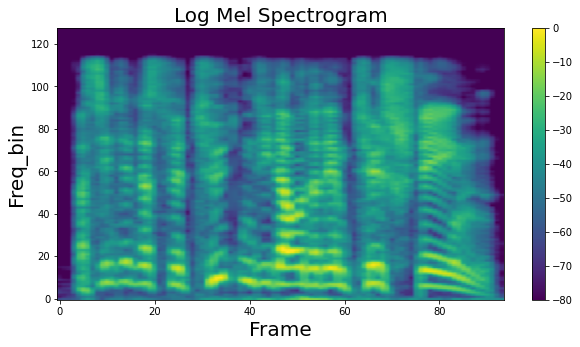

In [12]:
# Plot the Log-Mel-Spectrogram of the played example
mel_spec = librosa.feature.melspectrogram(y, sr)
log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
plot_spectrogram(log_mel_spec)

### Reading the wav files as torch tensors

In [13]:
audios = []
for file in tqdm(wav_files, desc='Loading Wav Files...'):
  #load audio file
  audio, sr = torchaudio.load(file)

  #resample data if needed
  if sr != 16000:
    audio = torchaudio.functional.resample(audio, orig_freq=sr, new_freq=16000)
  audios.append(audio.squeeze(0))

Loading Wav Files...: 100%|██████████| 535/535 [00:00<00:00, 1239.27it/s]


# Select subset of audios for quick test

In [14]:
import random
select_subset = True

if select_subset:
  audios = random.sample(audios, 20)

### Extract Hybrid BYOL-S Representations

In [15]:
# Load model with weights - located in the root directory of this repo
model_name = 'cvt'
checkpoint_path = "serab-byols/checkpoints/cvt_s1-d1-e64_s2-d1-e256_s3-d1-e512_BYOLAs64x96-osandbyolaloss6373-e100-bs256-lr0003-rs42.pth"
# Feed the feature extractor the list of audio tensors
model = serab_byols.load_model(checkpoint_path, model_name)
hybrid_byols_embeddings = serab_byols.get_scene_embeddings(audios, model)
hybrid_byols_embeddings = hybrid_byols_embeddings.cpu().detach().numpy()
print(f'\n Embeddings Shape: {hybrid_byols_embeddings.shape}')

Generating Embeddings...: 100%|██████████| 20/20 [00:01<00:00, 16.48it/s]


 Embeddings Shape: (20, 2048)


### Extract Wav2Vec2 Representations

In [16]:
# HuggingFace model hub
model_hub = "facebook/wav2vec2-base-960h"
model_huggingface = HuggingFaceWav2Vec2(model_hub, save_path="pretrained/")
wav2vec_embeddings = []
for audio in tqdm(audios):
  wav2vec_embeddings.append(model_huggingface(audio.unsqueeze(0)).mean(1).squeeze(0).cpu().detach().numpy())
wav2vec_embeddings = np.array(wav2vec_embeddings)
print(wav2vec_embeddings.shape)

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.bias', 'lm_head.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 20/20 [00:17<00:00,  1.16it/s]

(20, 768)


### Compute similarity using CKA and CCA.

In [17]:
def gram_linear(x):
  """Compute Gram (kernel) matrix for a linear kernel.

  Args:
    x: A num_examples x num_features matrix of features.

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  return x.dot(x.T)


def gram_rbf(x, threshold=1.0):
  """Compute Gram (kernel) matrix for an RBF kernel.

  Args:
    x: A num_examples x num_features matrix of features.
    threshold: Fraction of median Euclidean distance to use as RBF kernel
      bandwidth. (This is the heuristic we use in the paper. There are other
      possible ways to set the bandwidth; we didn't try them.)

  Returns:
    A num_examples x num_examples Gram matrix of examples.
  """
  dot_products = x.dot(x.T)
  sq_norms = np.diag(dot_products)
  sq_distances = -2 * dot_products + sq_norms[:, None] + sq_norms[None, :]
  sq_median_distance = np.median(sq_distances)
  return np.exp(-sq_distances / (2 * threshold ** 2 * sq_median_distance))


def center_gram(gram, unbiased=False):
  """Center a symmetric Gram matrix.

  This is equvialent to centering the (possibly infinite-dimensional) features
  induced by the kernel before computing the Gram matrix.

  Args:
    gram: A num_examples x num_examples symmetric matrix.
    unbiased: Whether to adjust the Gram matrix in order to compute an unbiased
      estimate of HSIC. Note that this estimator may be negative.

  Returns:
    A symmetric matrix with centered columns and rows.
  """
  if not np.allclose(gram, gram.T):
    raise ValueError('Input must be a symmetric matrix.')
  gram = gram.copy()

  if unbiased:
    # This formulation of the U-statistic, from Szekely, G. J., & Rizzo, M.
    # L. (2014). Partial distance correlation with methods for dissimilarities.
    # The Annals of Statistics, 42(6), 2382-2412, seems to be more numerically
    # stable than the alternative from Song et al. (2007).
    n = gram.shape[0]
    np.fill_diagonal(gram, 0)
    means = np.sum(gram, 0, dtype=np.float64) / (n - 2)
    means -= np.sum(means) / (2 * (n - 1))
    gram -= means[:, None]
    gram -= means[None, :]
    np.fill_diagonal(gram, 0)
  else:
    means = np.mean(gram, 0, dtype=np.float64)
    means -= np.mean(means) / 2
    gram -= means[:, None]
    gram -= means[None, :]

  return gram


def cka(gram_x, gram_y, debiased=False):
  """Compute CKA.

  Args:
    gram_x: A num_examples x num_examples Gram matrix.
    gram_y: A num_examples x num_examples Gram matrix.
    debiased: Use unbiased estimator of HSIC. CKA may still be biased.

  Returns:
    The value of CKA between X and Y.
  """
  gram_x = center_gram(gram_x, unbiased=debiased)
  gram_y = center_gram(gram_y, unbiased=debiased)

  # Note: To obtain HSIC, this should be divided by (n-1)**2 (biased variant) or
  # n*(n-3) (unbiased variant), but this cancels for CKA.
  scaled_hsic = gram_x.ravel().dot(gram_y.ravel())

  normalization_x = np.linalg.norm(gram_x)
  normalization_y = np.linalg.norm(gram_y)
  return scaled_hsic / (normalization_x * normalization_y)


def _debiased_dot_product_similarity_helper(
    xty, sum_squared_rows_x, sum_squared_rows_y, squared_norm_x, squared_norm_y,
    n):
  """Helper for computing debiased dot product similarity (i.e. linear HSIC)."""
  # This formula can be derived by manipulating the unbiased estimator from
  # Song et al. (2007).
  return (
      xty - n / (n - 2.) * sum_squared_rows_x.dot(sum_squared_rows_y)
      + squared_norm_x * squared_norm_y / ((n - 1) * (n - 2)))


def feature_space_linear_cka(features_x, features_y, debiased=False):
  """Compute CKA with a linear kernel, in feature space.

  This is typically faster than computing the Gram matrix when there are fewer
  features than examples.

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.
    debiased: Use unbiased estimator of dot product similarity. CKA may still be
      biased. Note that this estimator may be negative.

  Returns:
    The value of CKA between X and Y.
  """
  features_x = features_x - np.mean(features_x, 0, keepdims=True)
  features_y = features_y - np.mean(features_y, 0, keepdims=True)

  dot_product_similarity = np.linalg.norm(features_x.T.dot(features_y)) ** 2
  normalization_x = np.linalg.norm(features_x.T.dot(features_x))
  normalization_y = np.linalg.norm(features_y.T.dot(features_y))

  if debiased:
    n = features_x.shape[0]
    # Equivalent to np.sum(features_x ** 2, 1) but avoids an intermediate array.
    sum_squared_rows_x = np.einsum('ij,ij->i', features_x, features_x)
    sum_squared_rows_y = np.einsum('ij,ij->i', features_y, features_y)
    squared_norm_x = np.sum(sum_squared_rows_x)
    squared_norm_y = np.sum(sum_squared_rows_y)

    dot_product_similarity = _debiased_dot_product_similarity_helper(
        dot_product_similarity, sum_squared_rows_x, sum_squared_rows_y,
        squared_norm_x, squared_norm_y, n)
    normalization_x = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_x ** 2, sum_squared_rows_x, sum_squared_rows_x,
        squared_norm_x, squared_norm_x, n))
    normalization_y = np.sqrt(_debiased_dot_product_similarity_helper(
        normalization_y ** 2, sum_squared_rows_y, sum_squared_rows_y,
        squared_norm_y, squared_norm_y, n))

  return dot_product_similarity / (normalization_x * normalization_y)

In [18]:
cka_from_examples = cka(gram_linear(hybrid_byols_embeddings), gram_linear(wav2vec_embeddings))
cka_from_features = feature_space_linear_cka(hybrid_byols_embeddings, wav2vec_embeddings)

print('Linear CKA from Examples: {:.5f}'.format(cka_from_examples))
print('Linear CKA from Features: {:.5f}'.format(cka_from_features))

Linear CKA from Examples: 0.53134
Linear CKA from Features: 0.53134


In [19]:
def cca(features_x, features_y):
  """Compute the mean squared CCA correlation (R^2_{CCA}).

  Args:
    features_x: A num_examples x num_features matrix of features.
    features_y: A num_examples x num_features matrix of features.

  Returns:
    The mean squared CCA correlations between X and Y.
  """
  qx, _ = np.linalg.qr(features_x)  # Or use SVD with full_matrices=False.
  qy, _ = np.linalg.qr(features_y)
  return np.linalg.norm(qx.T.dot(qy)) ** 2 / min(
      features_x.shape[1], features_y.shape[1])

print('Mean Squared CCA Correlation: {:.5f}'.format(cca(hybrid_byols_embeddings, wav2vec_embeddings)))

Mean Squared CCA Correlation: 0.02604
